In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.chdir("..")

In [2]:
from typing import List, Tuple
import json
from pathlib import Path
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from pathlib import Path


def load_all_solution_labels(solution_label_files: List[Path] | Path):
    if isinstance(solution_label_files, Path):
        # solution_label_files is the parent folder of safetensor files
        solution_label_files = list[Path](solution_label_files.glob("solution_labels.*.jsonl"))

    all_samples = []
    for solution_label_file in solution_label_files:
        assert solution_label_file.suffix == ".jsonl", \
            "`gradient_files` should only include `.safetensor` files."
        with open(solution_label_file, 'r') as f:
            for line in f.readlines():
                all_samples.append(json.loads(line))
    return all_samples

In [10]:
samples_1 = load_all_solution_labels(Path("runs/aime24.qwen2.5-0.5b/sft_ep1.prefix"))

for s in samples_1:
    s['ep'] = 1

samples_9 = load_all_solution_labels(Path("runs/aime24.qwen2.5-0.5b/sft_ep9.prefix"))
for s in samples_9:
    s['ep'] = 9

samples = samples_1 + samples_9

In [11]:
samples[0]

{'id': 18226,
 'question_id': 22,
 'prompt': 'A list of positive integers has the following properties:\n$\\bullet$ The sum of the items in the list is $30$.\n$\\bullet$ The unique mode of the list is $9$.\n$\\bullet$ The median of the list is a positive integer that does not appear in the list itself.\nFind the sum of the squares of all the items in the list.',
 'prefix': 'The approach to solve this problem is',
 'completion': 'The approach to solve this problem is to find a list of positive integers that satisfies the given properties.',
 'is_valid': True,
 'is_correct': False,
 'claude_label': 'no_skill\n\nReason: The provided solution is merely a restatement of the problem without',
 'ep': 1}

In [12]:
len(samples)

1472

In [13]:
prefix_sols = defaultdict(list)
for sample in samples:
    # if sample['is_correct']:
    sol_label = sample['claude_label'].split()[0].split(',')[0].strip()
    sample['sol_label'] = sol_label
    prefix_sols[sample['prefix']].append(sol_label)

all_skills = []
for k, v in prefix_sols.items():
    v_filtered = [label for label in v if label != "no_skill"]
    print(k, len(v_filtered))
    all_skills.extend(list(set(v_filtered)))
all_skills = list(set(all_skills))

The approach to solve this problem is 1117


In [17]:
import re
from src.sampler.claude_sampler import ClaudeCompletionSampler
from src.sampler.gemini_sampler import GeminiSampler


grouping_template = r"""You are given a list of mathematical skills required to solve a problem:

<list-skills>

Your task is to reduce the number of unique skills by grouping similar skills into broader categories and assigning a clear, descriptive name to each category.

Guidelines:
    - Each category name should be descriptive and unambiguous.
    - Use concise wording.
    - Ensure that every original skill is included in exactly one category.
    - The categories should reflect meaningful mathematical groupings rather than superficial similarities.

Required output format (JSON):
    - Output a JSON object where keys are category names and values are lists of skill names.
    - Example:

```json
{
  "basic_arithmetic_operations": ["addition", "subtraction", "multiplication"],
  "fractions_and_percentages": ["addition_of_fractions", "understanding_fractions_and_inequalities", "percentages"],
  "average_and_proportion": ["average_calculation", "proportion_calculation"],
  "order_of_operations": ["order_of_operations"],
  "combinatorics_and_counting": ["counting", "permutations_combinations"]
}
```
"""

sampler = ClaudeCompletionSampler(
    # model="claude-sonnet-4-5-20250929",
    model="claude-haiku-4-5-20251001",
    max_tokens=2048,
)

# sampler = GeminiSampler(
#     # model="gemini-2.0-flash",
#     # model="gemini-2.5-pro",
#     model="gemini-2.5-flash",
#     system_message=None,
#     max_tokens=4196,
# )

prompt = grouping_template.replace("<list-skills>", f"[ {', '.join(all_skills)}]")
message_list = [
    {"role": "user", "content": prompt},
]
response = sampler(message_list)

def extract_json(response_text):
    """
    Extracts JSON code block(s) (delimited by ```json ... ```) from the given response text.
    Returns the parsed JSON object (dict or list). If multiple json blocks, returns a list of JSON objects.
    If not found, attempts to extract from generic triple-backtick blocks.
    If no valid JSON is found, returns None.
    """

    # Find `json`-annotated code blocks
    code_blocks = re.findall(r"```json(.*?)```", response_text, re.DOTALL | re.IGNORECASE)
    objects = []
    # Try all json-annotated blocks
    for block in code_blocks:
        try:
            obj = json.loads(block.strip())
            objects.append(obj)
        except Exception:
            continue
    if objects:
        return objects if len(objects) > 1 else objects[0]
    # Fallback: generic code block parsing if `json` was not specified
    generic_blocks = re.findall(r"```(.*?)```", response_text, re.DOTALL)
    for block in generic_blocks:
        block_stripped = block.strip()
        # Try: sometimes block may still be JSON without explicit markdown language
        try:
            obj = json.loads(block_stripped)
            return obj
        except Exception:
            continue
    return None

categories = extract_json(response.choices[0].response_text)

In [18]:
categories

{'constraint_satisfaction_and_solving': ['constraint_satisfaction',
  'solving_by_constraint_satisfaction',
  'constraint_satisfaction_problem',
  'constraint_based_problem_solving',
  'constraint_satisfaction_with_statistical_properties',
  'solving_with_constraints'],
 'constraint_analysis': ['analyzing_constraints',
  'analyzing_constraints_and_properties',
  'analyzing_constraints_from_statistical_properties',
  'arithmetic_constraints_and_list_properties'],
 'list_construction_and_manipulation': ['list_construction_from_constraints',
  'list_construction_and_analysis',
  'list_construction_and_constraint_satisfaction',
  'list_construction_and_constraints',
  'list_construction_with_constraints',
  'list_construction_and_properties'],
 'list_analysis_and_properties': ['list_properties_analysis',
  'analyzing_list_properties',
  'list_properties_analysis'],
 'statistical_analysis_and_reasoning': ['analyzing_statistical_constraints',
  'analyzing_statistical_properties',
  'understa

In [26]:
to_category = defaultdict(lambda: "unknown")
# to_category = {}
for k, v_list in categories.items():
    to_category[k] = k
    for v in v_list:
        to_category[v] = k

In [21]:
ep_sols = defaultdict(list)
for sample in samples:
    # if sample['is_correct']:
    sol_label = sample['claude_label'].split()[0].split(',')[0].strip()
    sample['sol_label'] = sol_label
    ep_sols[sample['ep']].append(sol_label)

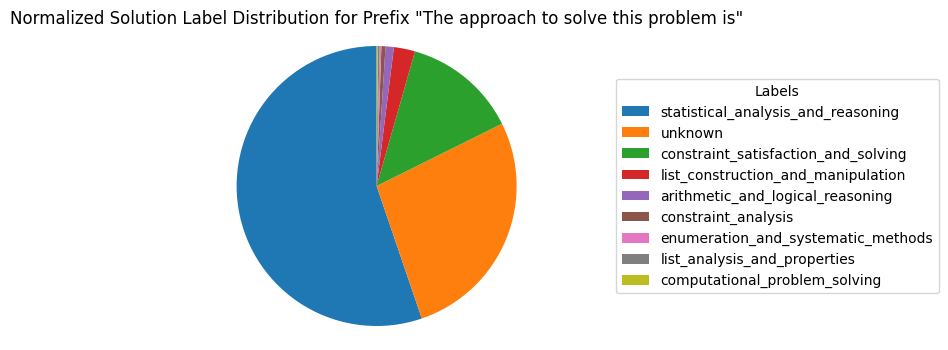

In [ ]:
for k, v in ep_sols.items():
    # Filter out "no_skill"
    v_filtered = [to_category[label] for label in v]
    if not v_filtered:
        continue
    counts = Counter(v_filtered)
    total_count = sum(counts.values())
    if total_count < 20:
        continue
    # Sort counts by value DESC, then by label ASC
    sorted_items = sorted(counts.items(), key=lambda x: (-x[1], x[0]))
    sorted_labels = [item for item, _ in sorted_items]
    sorted_counts = [count for _, count in sorted_items]
    normalized_counts = [count / total_count for count in sorted_counts]
    
    plt.figure(figsize=(6, 4))
    wedges, texts = plt.pie(
        normalized_counts,
        labels=None,  # Remove labels from the pie chart
        autopct=None, # No percentage on pie slices
        startangle=90,
    )
    plt.title(f'Normalized Solution Label Distribution for Prefix "{k}"')
    plt.axis('equal')  # Ensure pie chart is a circle
    plt.legend(
        wedges,
        sorted_labels,
        title="Labels",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )
    plt.show()

In [17]:
import json

with open("/scratch1/hnn5071/workspace/rm-limeval/vrevals/runs/v1/inspect/divmind_140/dataset.jsonl", "w", encoding="utf-8") as f:
    for sample in samples:
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")

In [41]:
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer

In [45]:
stop = stopwords.words('english')
tk = WhitespaceTokenizer()
stemmer = SnowballStemmer("english")

In [50]:
ngram_data = []
for sample in samples:
    prefix = " ".join(sample['completion'].split(" ")[:50]).lower()
    if sample['sol_label'] != "no_skill":
        if sample['sol_label'] in to_category:
            sample['sol_label'] = to_category[sample['sol_label']]
        else:
            sample['sol_label'] = "no_skill"
    if sample['sol_label'] == "no_skill":
        continue
    sample['tokenised'] = tk.tokenize(prefix)
    sample['stemmed'] = [stemmer.stem(y) for y in sample['tokenised']]
    sample['stemmed_without_stop'] = ' '.join([word for word in sample['stemmed'] if word not in (stop)])
    ngram_data.append(sample)

In [52]:
labels = [s['sol_label'] for s in ngram_data]
le = preprocessing.LabelEncoder()
le.fit(labels)

LabelEncoder()

In [53]:
y = le.transform(labels)

In [59]:
flat_list_transcription = [s['stemmed_without_stop'] for s in ngram_data]

In [60]:
n_gram_features ={'unigram':(1,1),'unigram_bigram':(1,2),'bigram':(2,2),\
       'bigram_trigram':(2,3),'trigram':(3,3)}
feature_name=[]
temp=[]
for key, values in n_gram_features.items():
    temp.append(key)
    feature_name.append(key)
temp

['unigram', 'unigram_bigram', 'bigram', 'bigram_trigram', 'trigram']

In [61]:
def generate_n_gram_features(flat_list_transcription):
    temp=[]
    for key, values in n_gram_features.items(): 
        vectorizer = CountVectorizer(ngram_range=values)
        vectorizer.fit(flat_list_transcription)
        temp.append(vectorizer.transform(flat_list_transcription))
    return temp
temp = generate_n_gram_features(flat_list_transcription)

In [64]:
dataframes = {'unigram':temp[0], 
              'unigram_bigram':temp[1], 
              'bigram':temp[2], 
              'bigram_trigram':temp[3], 
              'trigram':temp[4]}
feature_vector = [] ; feature_vector_shape = []
for key in dataframes:
    feature_vector.append(key)
    feature_vector_shape.append(dataframes[key].shape)

n_gram_df = pd.DataFrame({'N-Gram Feature Vector':feature_vector, 'Data Dimension':feature_vector_shape})
n_gram_df

,N-Gram Feature Vector,Data Dimension
0,unigram,"(612, 443)"
1,unigram_bigram,"(612, 2496)"
2,bigram,"(612, 2053)"
3,bigram_trigram,"(612, 5924)"
4,trigram,"(612, 3871)"


In [66]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
random_state_number =8888
df_target = y

In [67]:
metrics = {
    'f1':[f1_score, 'f1_macro'], 
    'precision': [precision_score, 'precision_macro'], 
    'recall': [recall_score, 'recall_macro']
}

# get evaluation result

def get_performance(param_grid, base_estimator, dataframes):
    df_name_list =[]; best_estimator_list=[]; best_score_list=[]; test_predict_result_list=[];
    metric_list = [];
    
    for df_name, df in dataframes.items():
        
        X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=random_state_number)
        for _, metric_dict in metrics.items():
            sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, scoring=metric_dict[1],random_state=random_state_number,
                                      factor=2).fit(X_train, y_train)

            best_estimator = sh.best_estimator_
            clf = best_estimator.fit(X_train, y_train)
            prediction = clf.predict(X_test)
            test_predict_result = metric_dict[0](y_test, prediction, average='macro')

            df_name_list.append(df_name) ; best_estimator_list.append(best_estimator) ; 
            best_score_list.append(sh.best_score_) ; 
            test_predict_result_list.append(test_predict_result) ;metric_list.append(metric_dict[1])
            
            
    model_result = pd.DataFrame({'Vector':df_name_list,'Metric':metric_list,
                               'Calibrated Estimator':best_estimator_list,
                               'Best CV Metric Score':best_score_list, 'Test Predict Metric Score': test_predict_result_list})
    return model_result

In [69]:
import matplotlib
import numpy as np

In [70]:
font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

def vis_classification(vector_type = 'unigram', estimator = KNeighborsClassifier(n_neighbors=9)):
    pca = PCA(n_components=2)
    df1 = pca.fit_transform(dataframes[vector_type].todense())
    X_train, X_test, y_train, y_test = train_test_split(df1, df_target, test_size=0.2, random_state=random_state_number)
    
    # get training set
    df2 = pd.DataFrame({'pca1':X_train[:,1], 'pca2': X_train[:,0], 'y':le.inverse_transform(y_train)})
    min_1, max_1 = df2['pca1'].min(), df2['pca1'].max()
    min_2, max_2 = df2['pca2'].min(), df2['pca2'].max()
    
    # generate dimension reduced, but extended data
    pca1_range = np.linspace(min_1,max_1,30)
    pca2_range = np.linspace(min_2,max_2,30)
    
    # shuffle
    np.random.shuffle(pca1_range) ; np.random.shuffle(pca2_range)
    
    # to dataframe
    prediction_test = pd.DataFrame({'pca1':pca1_range, 'pca2':pca2_range})

    best_estimator = estimator
    
    # fit training set and predict extended data
    clf = best_estimator.fit(X_train, y_train)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6))
    cmap = plt.cm.get_cmap('tab10', 4)
    fig.suptitle(f"Visualising {type(estimator).__name__} on {vector_type.capitalize()} Vector", fontsize=14,fontweight='bold')


    def plot_scatter(ax, predictor_set, target, title):
        
        # plot area classifier
        clf = best_estimator.fit(X_train, y_train)
        axs[0].tricontourf(X_train[:,0], X_train[:,1], clf.predict(X_train), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")
        
        axs[1].tricontourf(X_test[:,0], X_test[:,1], clf.predict(X_test), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")
        
        # plot scatter
        df3 = pd.DataFrame({'pca1':predictor_set[:,1], 'pca2': predictor_set[:,0], 'y':le.inverse_transform(target)})
        for y_label in df3['y'].unique():
            df_filter = df3[df3['y']==y_label]
            ax.scatter(df_filter['pca1'], df_filter['pca2'], alpha=1,label=f"{y_label}")
        ax.legend()
        ax.set_title(f'{title} ({predictor_set.shape[0]} Samples)',fontweight='bold')
    plot_scatter(axs[0], X_train, y_train, 'Training Set')
    plot_scatter(axs[1], X_test, y_test, 'Testing Set')
    axs[0].sharey(axs[1])
    return plt.show()

In [71]:
param_grid = {'max_depth': [None,30,32,35,37,38,39,40],'min_samples_split': [2,150,170,180,190,200]}
base_estimator = RandomForestClassifier(random_state=random_state_number)
rfc_result = get_performance(param_grid, base_estimator, dataframes)
rfc_result

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=39, max_feat...",0.200077,0.193043
1,unigram,precision_macro,"(DecisionTreeClassifier(max_depth=32, max_feat...",0.228392,0.238116
2,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=38, max_feat...",0.198103,0.194312
3,unigram_bigram,f1_macro,"(DecisionTreeClassifier(max_features='sqrt', r...",0.180571,0.162370
4,unigram_bigram,precision_macro,"(DecisionTreeClassifier(max_features='sqrt', r...",0.206797,0.240567
5,unigram_bigram,recall_macro,"(DecisionTreeClassifier(max_depth=32, max_feat...",0.185074,0.180026
6,bigram,f1_macro,"(DecisionTreeClassifier(max_depth=38, max_feat...",0.186255,0.155906
7,bigram,precision_macro,"(DecisionTreeClassifier(max_depth=38, max_feat...",0.231143,0.261293
8,bigram,recall_macro,"(DecisionTreeClassifier(max_depth=38, max_feat...",0.193227,0.142063
9,bigram_trigram,f1_macro,"(DecisionTreeClassifier(max_depth=39, max_feat...",0.180785,0.142680
